<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prologue" data-toc-modified-id="Prologue-1">Prologue</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2">Setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-2.1">Imports</a></span></li><li><span><a href="#Define-the-geographic-area-of-interest" data-toc-modified-id="Define-the-geographic-area-of-interest-2.2">Define the geographic area of interest</a></span></li></ul></li><li><span><a href="#Data-acquisition,-cleaning,-&amp;-exploration" data-toc-modified-id="Data-acquisition,-cleaning,-&amp;-exploration-3">Data acquisition, cleaning, &amp; exploration</a></span><ul class="toc-item"><li><span><a href="#Foursquare-Venues" data-toc-modified-id="Foursquare-Venues-3.1">Foursquare Venues</a></span></li><li><span><a href="#Venue-categories,-groups,-&amp;-types" data-toc-modified-id="Venue-categories,-groups,-&amp;-types-3.2">Venue categories, groups, &amp; types</a></span></li><li><span><a href="#Vizualizing-venues" data-toc-modified-id="Vizualizing-venues-3.3">Vizualizing venues</a></span></li></ul></li><li><span><a href="#Modeling-&amp;-evaluation" data-toc-modified-id="Modeling-&amp;-evaluation-4">Modeling &amp; evaluation</a></span></li></ul></div>

# Getting to know Rexburg, Idaho, USA
**Where to live, where to eat, what to do**

_Coursera Applied Data Science Capstone Project, January 2020_

## Prologue

## Setup

### Imports

In [1]:
import math
import numpy as np
import pandas as pd
import requests

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium
from folium.features import DivIcon

import capstone_functions as cf

from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

### Define the geographic area of interest

Rexburg's four corners:
- NW: 43.840199, -111.807453
- NE: 43.840199, -111.757579
- SW: 43.804226, -111.807453
- SE: 43.804226, -111.757579

4km square

In [2]:
SE = np.array([43.804226, -111.757579])
SW = np.array([43.804226, -111.807453])
NW = np.array([43.840199, -111.807453])
NE = np.array([43.840199, -111.757579])
CORNERS = np.array([SE, SW, NW, NE])

grid_size = 8

# Calculate radius to cover grid section diagonals and round to
# the next highest 10
radius = math.ceil((((((4_000 / grid_size)**2)*2)**0.5)/2)/10)*10

grid_segment_centers = cf.grid_centers(CORNERS, grid_size)
grid_squares = cf.grid_square_bounds(CORNERS, grid_size)

map_center = (round(np.mean([lat for lat, long in CORNERS]), 6), 
              round(np.mean([long for lat, long in CORNERS]), 6))

In [3]:
map_rexburg = folium.Map(location=map_center, zoom_start=13)

folium.Rectangle(
    [each for each in CORNERS[::2]], color='gray', weight=2
    ).add_to(map_rexburg)

counter = 1
for row in grid_squares:
    for square in row:
        folium.Rectangle(
            square,
            fill=False,
            weight=0.5,
            color='gray'
            ).add_to(map_rexburg)

        folium.map.Marker(
            [grid_segment_centers[counter-1][0], 
             grid_segment_centers[counter-1][1]],
            icon=DivIcon(icon_size=(10,10),
                         icon_anchor=(10,10),
                         html=f'<div style="text-align:center;font-size: 10pt"'
                              f'>{counter}</div>')
            ).add_to(map_rexburg)

        counter += 1
        
# for lat, long in grid_segment_centers:
#     folium.Circle(
#         [lat, long],
#         radius=radius,
#         fill=True,
#         fill_opacity=0.2,
#         weight=0.3
#         ).add_to(map_rexburg)

map_rexburg

## Data acquisition, cleaning, & exploration

### Foursquare Venues

In [4]:
rexburg_venues = cf.get_nearby_venues(range(1, grid_size**2 + 1), 
                                      grid_segment_centers[:, 0], 
                                      grid_segment_centers[:, 1], 
                                      radius=radius)
print(f'\n{rexburg_venues.shape[0]} venues retrieved.')

Getting grid sections: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 
6098 venues retrieved.


In [5]:
rexburg_venues.drop_duplicates(['venue', 'v_lat', 'v_long'], inplace=True)
print(f'{rexburg_venues.shape[0]} remain after dropping duplicates.')

877 remain after dropping duplicates.


In [6]:
for row in rexburg_venues.itertuples():
    rexburg_venues.loc[row.Index, 
                       'grid_section'] = cf.venue_grid_section(row.v_lat, 
                                                               row.v_long, 
                                                               grid_squares)

In [7]:
rexburg_venues.grid_section.isnull().sum()

95

In [8]:
rexburg_venues.dropna(inplace=True)
rexburg_venues.isnull().sum().sum()

0

In [9]:
rexburg_venues.grid_section = rexburg_venues.grid_section.astype(int)

In [10]:
map_venues = folium.Map(location=map_center, zoom_start=13)

folium.Polygon(
    [each for each in CORNERS], color='gray', weight=2
    ).add_to(map_venues)

for lat, long, label in zip(rexburg_venues.v_lat, 
                            rexburg_venues.v_long, 
                            rexburg_venues.venue):
    folium.CircleMarker(
        [lat, long],
        radius=3,
        popup=label,
        fill=True,
        color='black',
        fill_color='black',
        fill_opacity=0.25,
        weight=1
        ).add_to(map_venues)

counter = 1
for square, center in zip(grid_squares.reshape(-1, 2, 2), 
                          grid_segment_centers):
    folium.Rectangle(
        square,
        color='gray',
        fill=False,
        weight=0.5,
        ).add_to(map_venues)

    folium.map.Marker(
        center,
        icon=DivIcon(icon_size=(1,1),
                     icon_anchor=(10,10),
                     html=f'<div style="text-align:center;font-size:12pt;'
                          f'color:gray;font-weight:bold">{counter}</div>')
        ).add_to(map_venues)
    counter += 1
    
map_venues

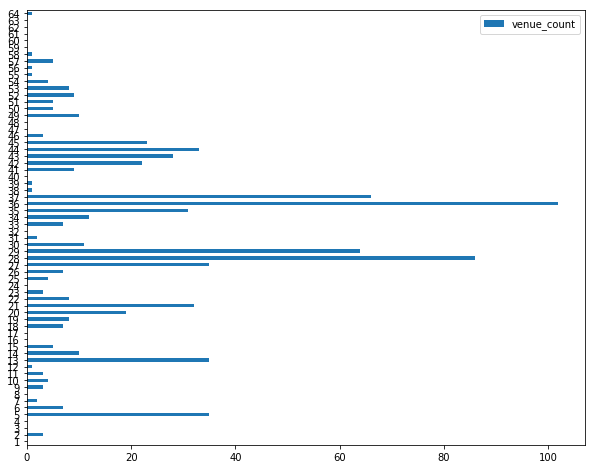

In [11]:
section_venues = pd.DataFrame(index=range(1, grid_size**2 + 1)
                             ).join(rexburg_venues['grid_section'].value_counts())
section_venues.columns = ['venue_count']
section_venues.plot.barh(figsize=(10,8));

In [12]:
len(rexburg_venues[rexburg_venues['category'].str.contains('None')
                  ].sort_values(by='venue').iloc[:, -4:])

30

In [13]:
# [Delete]
venues_to_delete = (
"""Alterra Pest Control
CALl
Dr. Gates
SSI
Spencer W. Kimball 292 Conference Room
The Dorms
The Hays'
The Lions Den
The Minariks
The Moseley's
Williams Engineering Buiding
wwe Universe
Upper Valley Vet
""".splitlines())

rexburg_venues.drop(
    rexburg_venues[(rexburg_venues['venue'].isin(venues_to_delete)) & 
                   (rexburg_venues['category'] == 'None')].index,
    inplace=True)

In [14]:
category_updates = {}

# Automotive Shop
category_updates = cf.add_category_change(
    'Automotive Shop',
    "0500 Mechanics|Tire Factory".split('|'), 
    category_updates)

# Church
category_updates = cf.add_category_change(
    'Church', 
    ['Stonebridge Ward Chapel'], 
    category_updates)

# College Administrative Building
category_updates = cf.add_category_change(
    'College Administrative Building',
    "BYU-Idaho Alumni Center|Ricks Hall".split('|'), 
    category_updates)

# High School
category_updates = cf.add_category_change(
    'High School',
    ['Madison High School'], 
    category_updates)

# Hotel
category_updates = cf.add_category_change(
    'Hotel',
    "Comfort Inn|Days Inn".split('|'), 
    category_updates)

# Lighting Store
category_updates = cf.add_category_change(
    'Lighting Store', 
    ['Wolfe Lighting & Accents'], 
    category_updates)

# Mexican Restaurant
category_updates = cf.add_category_change(
    'Mexican Restaurant',
    "Izcalli Mexican Food|Tacos Izcalii|Taqueria la Fondita".split('|'), 
    category_updates)

# Movie Theater
category_updates = cf.add_category_change(
    'Movie Theater', 
    ['paramount twin'], 
    category_updates)

# Park
category_updates = cf.add_category_change(
    'Park', 
    ['Slide Hill'], 
    category_updates)

# Post Office
category_updates = cf.add_category_change(
    'Post Office', 
    ['USPS office'], 
    category_updates)

# Real Estate Office
category_updates = cf.add_category_change(
    'Real Estate Office', 
    ['Century 21'], 
    category_updates)

# Residential Building (Apartment / Condo)
category_updates = cf.add_category_change(
    'Residential Building (Apartment / Condo)',
    "Aalita|Greenbrier|Twin Pines Manor|West Tisbury|Allen Ridge".split('|'), 
    category_updates)

# Tanning Salon
category_updates = cf.add_category_change(
    'Tanning Salon',
    ['Radiance Tanning & Salon'], 
    category_updates)

In [15]:
for new_category, venues_to_change in category_updates.items():
    rexburg_venues.loc[
        (rexburg_venues['venue'].isin(venues_to_change)) & 
        (rexburg_venues['category'] == 'None'),
        'category'] = new_category

In [16]:
rexburg_venues[rexburg_venues['category'].str.contains('None')
              ].sort_values(by='venue').iloc[:, -4:]

,venue,v_lat,v_long,category


In [17]:
if len(rexburg_venues[rexburg_venues['category'].str.contains('None')]) != 0:
    raise ValueError(
            'Blank categories exist and must be resolved. See cell above.')

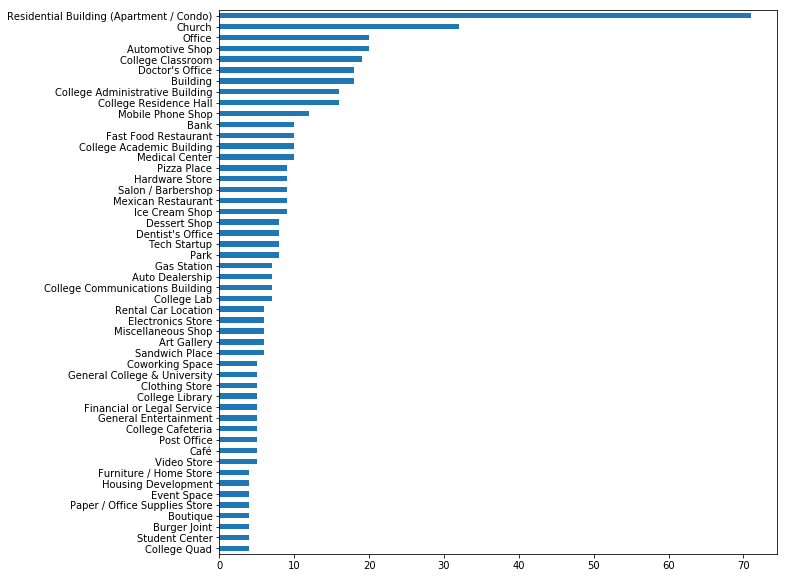

In [18]:
rexburg_venues['category'].value_counts().sort_values()[-50:].plot.barh(
    figsize=(10,10));

### Venue categories, groups, & types

In [19]:
cf.categories.shape

(941, 3)

In [20]:
rexburg_venues['group'] = rexburg_venues['category'].apply(
    lambda x: cf.map_category_group(x, 1))
rexburg_venues['type'] = rexburg_venues['category'].apply(
    lambda x: cf.map_category_group(x, 0))
rexburg_venues.head()

,grid_section,grid_section_lat,grid_section_long,venue,v_lat,v_long,category,group,type
0,2,43.837951,-111.804336,Eagle park,43.837360,-111.798076,Park,Park,Outdoors & Recreation
2,18,43.837951,-111.804336,The Church of Jesus Christ of Latter-day Saints,43.829912,-111.800706,Church,Spiritual Center,Professional & Other Places
3,9,43.837951,-111.804336,Nature Park,43.834798,-111.801264,Park,Park,Outdoors & Recreation
4,18,43.837951,-111.804336,Madison County Fair,43.830932,-111.796751,Flea Market,Flea Market,Shop & Service
7,10,43.837951,-111.804336,Eagle Park Campgrounds,43.835394,-111.796360,Campground,Campground,Outdoors & Recreation


In [21]:
rexburg_apartments = rexburg_venues[rexburg_venues['category'
                                                  ].str.contains('Resid')]
rexburg_food = rexburg_venues[rexburg_venues['type'
                                            ].str.contains('Food')]
rexburg_recreation = rexburg_venues[rexburg_venues['type'
                                                  ].str.contains('Outd')]

### Vizualizing venues

In [22]:
map_venues = folium.Map(location=map_center, zoom_start=13)

folium.Polygon(
    [each for each in CORNERS], color='gray', weight=2
    ).add_to(map_venues)

for lat, long, label in zip(rexburg_apartments.v_lat, 
                            rexburg_apartments.v_long, 
                            rexburg_apartments.venue):
    folium.CircleMarker(
        [lat, long],
        radius=3,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.5,
        weight=1
        ).add_to(map_venues)

for lat, long, label in zip(rexburg_food.v_lat, 
                            rexburg_food.v_long, 
                            rexburg_food.venue):
    folium.CircleMarker(
        [lat, long],
        radius=3,
        popup=label,
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=0.5,
        weight=1
        ).add_to(map_venues)

for lat, long, label in zip(rexburg_recreation.v_lat, 
                            rexburg_recreation.v_long, 
                            rexburg_recreation.venue):
    folium.CircleMarker(
        [lat, long],
        radius=3,
        popup=label,
        fill=True,
        color='green',
        fill_color='green',
        fill_opacity=0.5,
        weight=1
        ).add_to(map_venues)

counter = 1
for square, center in zip(grid_squares.reshape(-1, 2, 2), 
                          grid_segment_centers):
    folium.Rectangle(
        square,
        color='gray',
        fill=False,
        weight=0.5,
        ).add_to(map_venues)

    folium.map.Marker(
        center,
        icon=DivIcon(icon_size=(1,1),
                     icon_anchor=(10,10),
                     html=f'<div style="text-align:center;font-size:12pt;'
                          f'color:gray;font-weight:bold">{counter}</div>')
        ).add_to(map_venues)
    counter += 1
    
map_venues

## Modeling & evaluation

In [23]:
grid_categories = pd.crosstab(rexburg_venues.grid_section, rexburg_venues.group)
grid_categories = pd.DataFrame(index=range(1, grid_size**2 + 1)
                              ).join(grid_categories).fillna(0)
grid_categories.head()

,ATM,Airport,American Restaurant,Animal Shelter,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,...,Strip Club,Student Center,Tanning Salon,Tea Room,Thrift / Vintage Store,Trade School,Trail,University,Video Game Store,Video Store
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [24]:
grid_categories_scaled = grid_categories / grid_categories.max().max()
grid_categories_scaled.shape

(64, 154)

In [25]:
results = []

for clusters in range(2, grid_size**2):
    km = KMeans(n_clusters=clusters, n_jobs=-1, random_state=1280)
    km.fit(grid_categories_scaled)
    result = km.get_params()
    result['labels_'] = km.labels_
    result['inertia'] = km.inertia_
    try:
        result['silhouette_score'] = silhouette_score(grid_categories_scaled, 
                                                      km.labels_)
    except ValueError:
        result['silhouette_score'] = None
    results.append(result)

/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (49) found smaller than n_clusters (50). Possibly due to duplicate points in X.
  return_n_iter=True)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (49) found smaller than n_clusters (51). Possibly due to duplicate points in X.
  return_n_iter=True)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (49) found smaller than n_clusters (52). Possibly due to duplicate points in X.
  return_n_iter=True)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (49) found smaller than n_clusters (53). Possibly due to duplicate points in X.
  return_n_iter=True)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct c

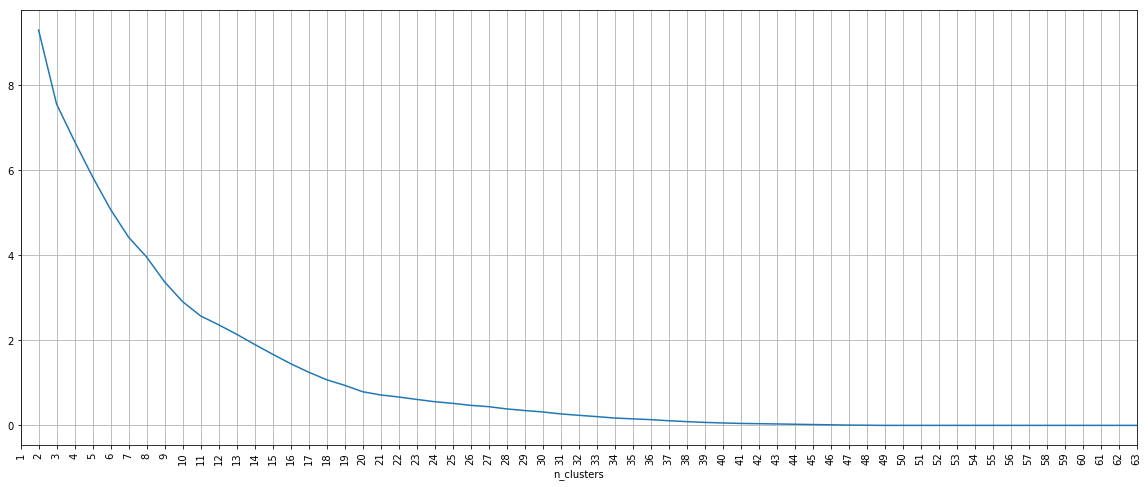

In [33]:
km_results = pd.DataFrame(results).set_index('n_clusters')
km_results['inertia'].plot(xticks=range(1, grid_size**2), 
                           figsize=(20,8), 
                           rot=90)
plt.grid(axis='both');

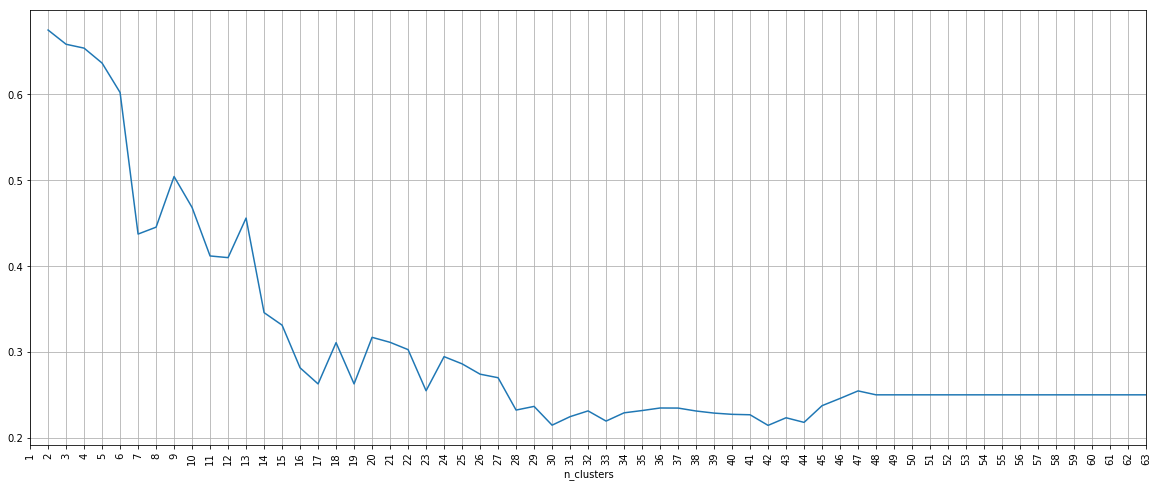

In [34]:
km_results['silhouette_score'].plot(xticks=range(1, grid_size**2), 
                                    figsize=(20,8),
                                    rot=90)
plt.grid(axis='both');

In [36]:
kclusters = 13
km_results.loc[kclusters, 'inertia':'silhouette_score']

inertia              2.14542
silhouette_score    0.455978
Name: 13, dtype: object

In [37]:
grid_categories['cluster'] = km_results.loc[kclusters].labels_ + 1
grid_categories['grid_section_lat'] = grid_segment_centers[:, 0]
grid_categories['grid_section_long'] = grid_segment_centers[:, 1]

In [38]:
grid_categories['cluster'].value_counts()

2     51
6      2
13     1
12     1
11     1
10     1
9      1
8      1
7      1
5      1
4      1
3      1
1      1
Name: cluster, dtype: int64

In [42]:
# create map
map_clusters = folium.Map(location=map_center, zoom_start=13)

folium.Polygon(
    [each for each in CORNERS], color='gray', weight=2
    ).add_to(map_clusters)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.tab10(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for (lat, lon, poi, 
    cluster, square, center) in zip(grid_categories['grid_section_lat'], 
                                   grid_categories['grid_section_long'], 
                                   grid_categories.index, 
                                   grid_categories['cluster'],
                                   grid_squares.reshape(-1, 2, 2),
                                   grid_segment_centers):
    
    label = folium.Popup(f'Grid {poi}' + ' Cluster ' + str(cluster + 1))

    folium.Rectangle(
        square,
        popup=label,
        color='gray',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.25,
        weight=0.5,
        ).add_to(map_clusters)

    folium.map.Marker(
        center,
        icon=DivIcon(icon_size=(0,0),
                     icon_anchor=(5,5),
                     html=f'<div style="text-align:center;font-size:10pt;'
                          f'color:#2C66AB;font-weight:bold">{cluster}</div>')
        ).add_to(map_clusters)
       
map_clusters

In [41]:
# create map
map_final = folium.Map(location=map_center, zoom_start=13)

folium.Polygon(
    [each for each in CORNERS], color='gray', weight=2
    ).add_to(map_final)

for lat, long, label in zip(rexburg_venues.v_lat, 
                            rexburg_venues.v_long, 
                            rexburg_venues.venue):
    folium.CircleMarker(
        [lat, long],
        radius=2,
        popup=label,
        fill=True,
        color='gray',
        fill_color='gray',
        fill_opacity=0.25,
        weight=0.5
        ).add_to(map_final)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.tab10(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for (lat, lon, poi, 
    cluster, square, center) in zip(grid_categories['grid_section_lat'], 
                                   grid_categories['grid_section_long'], 
                                   grid_categories.index, 
                                   grid_categories['cluster'],
                                   grid_squares.reshape(-1, 2, 2),
                                   grid_segment_centers):
    
    label = folium.Popup(f'Grid {poi}' + ' Cluster ' + str(cluster + 1))

    folium.Rectangle(
        square,
        popup=label,
        color='gray',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.25,
        weight=0.5,
        ).add_to(map_final)

    folium.map.Marker(
        center,
        icon=DivIcon(icon_size=(0,0),
                     icon_anchor=(5,5),
                     html=f'<div style="text-align:center;font-size:10pt;'
                          f'color:#2C66AB;font-weight:bold">{cluster}</div>')
        ).add_to(map_final)
       
map_final

----